<a href="https://colab.research.google.com/github/dawoodwasif/Digital-Image-Processing-Techniques/blob/main/DIP_Lab_11_Implement_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**DIP Lab 11**

---


### Dawood Wasif (289048)


In [ ]:
# necessary imports
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from skimage.morphology import reconstruction
from scipy.stats import mode


In [ ]:
# read image into input and read green channel
input = (cv2.imread('input_image.tif'))[:, :, 1]


## **Pre-processing**

### Background Normalization

In [ ]:
# store blurred output image array 
blurred = cv2.blur(input, (31,31))

# add input and blurred array and take absolute to get background normalized array
#bg_normalized = np.abs(input.astype(int) - blurred.astype(int)).astype('uint8')
bg_normalized = cv2.subtract(blurred,input)
#cv2.normalize(bg_normalized, bg_normalized, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)

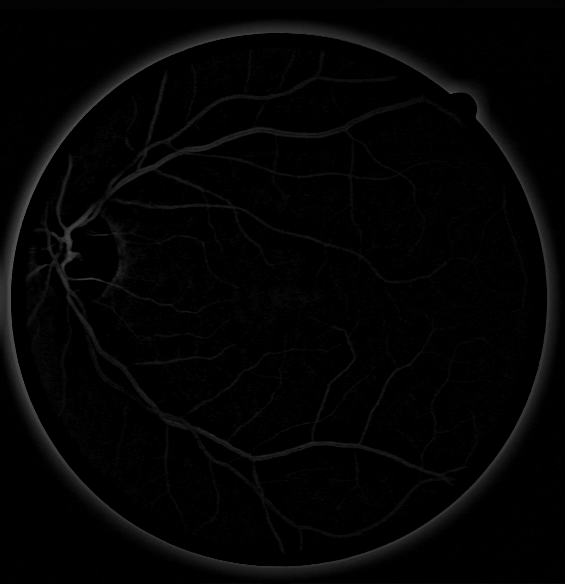

In [ ]:
Image.fromarray(bg_normalized)

### Thin vessel enhancement

In [ ]:
# use pre-defined line filter, rotated each time, given in document
line_filter1 = np.array([
                [-1, -1, -1],
                [ 2,  2,  2],
                [-1, -1, -1]
                ]) / 6

line_filter2 = np.array([
                [-1, -1,  2],
                [-1,  2, -1],
                [2,  -1, -1]
                ]) / 6

line_filter3 = np.array([
                [-1,  2, -1],
                [-1,  2, -1],
                [-1,  2, -1]
                ]) / 6

line_filter4 = np.array([
                [2,  -1, -1],
                [-1,  2, -1],
                [-1, -1,  2]
                ]) / 6


# store results in respective reslt arrays
result1 = cv2.filter2D(bg_normalized, -1, line_filter1)
result2 = cv2.filter2D(bg_normalized, -1, line_filter2)
result3 = cv2.filter2D(bg_normalized, -1, line_filter3)
result4 = cv2.filter2D(bg_normalized, -1, line_filter4)


# set up empty array of images 
width, height, num = (input.shape[0], input.shape[1], 4)
images = np.zeros((width, height, num), np.uint8)

# individually set each array value
images[:, :, 0] = result1
images[:, :, 1] = result2
images[:, :, 2] = result3
images[:, :, 3] = result4

# achieve final result with maximum of axis 2
final_result = images.max(axis = 2)

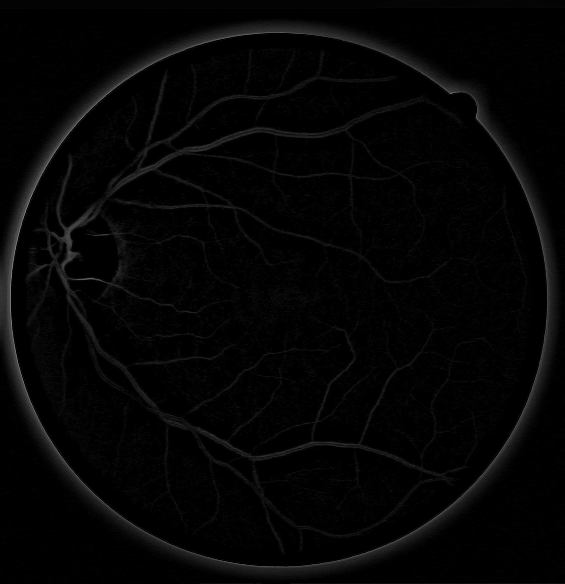

In [ ]:
# add the final result with background normalized image to get final array
enhanced = final_result + bg_normalized
Image.fromarray(enhanced)

## **Task1:** Vessel Centerline Detection

### Candidate Selection

In [ ]:
def get_doog_img(img, angle=0):
    '''Get Difference of Offset Gaussian Response'''
    assert angle in (0, 45, 90, 135), "ILLEGAL VALUE OF ANGLE; MUST BE ONE OF (0, 45, 90, 135)"
    if angle == 0: # vertical
        kernel = np.array([
                           [-1, -2, 0, 2, 1],
                           [-2, -4, 0, 4, 2],
                           [-1, -2, 0, 2, 1]  
        ])
    elif angle == 45: 
        kernel = np.array([
                           [-1, -4, -2, 0, 1],
                           [-2, -2, 0, 2, 2],
                           [-1, 0, 2, 4, 1]
       ])
    elif angle == 90:
        kernel = np.array([
                            [ 1,  2,  4,  2,  1],
                            [ 0,  0,  0,  0,  0],
                            [-1, -2, -4, -2, -1]
        ])
    else: # horizontal
        kernel = np.array([
                           [-1, 0, 2, 4, 1],
                           [-2, -2, 0, 2, 2],
                           [-1, -4, -2, 0, 1]
        ])
    response = cv2.filter2D(img, cv2.CV_32F, kernel)
    return response.astype('int32')

def get_centerline_candidates(img, angle=0):
    '''
    Combinations of derivative signs and average derivative values
    (1) ++--
    (2) ++-x ; ADV > 0
    (3) x+-- ; ADV < 0
    (4) +0-
    ''' 
    response = get_doog_img(img, angle)
    rows, cols = img.shape
    result = np.zeros(img.shape, dtype='int32')

    # sliding window
    for r in range(rows):
        for c in range(cols-3):
            # responses from filter
            v1 = response[r, c].item()
            v2 = response[r, c + 1].item()
            v3 = response[r, c + 2].item()
            v4 = response[r, c + 3].item()
            # average derivative value
            ADV = response[r, c:c + 4].mean()

            # intensities from image
            i1 = img[r, c].item()
            i2 = img[r, c + 1].item()
            i3 = img[r, c + 2].item()
            i4 = img[r, c + 3].item()

            # condition (1)
            cond1 = (v1 > 0) and (v2 > 0) and (v3 < 0) and (v4 < 0)
            # condition (2)
            cond2 = (v1 > 0) and (v2 > 0) and (v3 < 0) and (ADV > 0)
            # condition (3)
            cond3 = (v2 > 0) and (v3 < 0) and (v4 < 0) and (ADV < 0)
            # condition (4)
            cond4 = (v1 > 0) and (v2 == 0) and (v3 < 0)

            '''
            The final centerline candidate is simply the pixel with the maximum 
            intensity in the normalized image.
            This fact is registered in a new image by assigning at these coordinates 
            the sum of the highest positive response with the absolute value of the
            most negative response.
            '''
            if cond1 or cond2 or cond3:
                max_pixel = max(i1, i2, i3, i4)
                if max_pixel == i1:
                    coord = (r, c)
                elif max_pixel == i2:
                    coord = (r, c + 1)
                elif max_pixel == i3:
                    coord = (r, c + 2)
                else:
                    coord = (r, c + 3)
                res = max(v1, v2) + abs(min(v3, v4))
                # quantize values > 255 to 255
                res = res if res <= 255 else 255
                result[coord] = res
            elif cond4:
                max_pixel = max(i1, i2, i3)
                if max_pixel == i1:
                    coord = (r, c)
                elif max_pixel == i2:
                    coord = (r, c + 1)
                else:
                    coord = (r, c + 2)
                res = v1 + abs(v3)
                # quantize values > 255 to 255
                res = res if res <= 255 else 255
                result[coord] = res
    return result

In [ ]:
# vertical 
c1 = get_centerline_candidates(enhanced).astype('uint8')
# 45
c2 = get_centerline_candidates(enhanced, 45).astype('uint8')
# horizontal
c3 = get_centerline_candidates(enhanced, 90).astype('uint8')
# 135
c4 = get_centerline_candidates(enhanced, 135).astype('uint8')

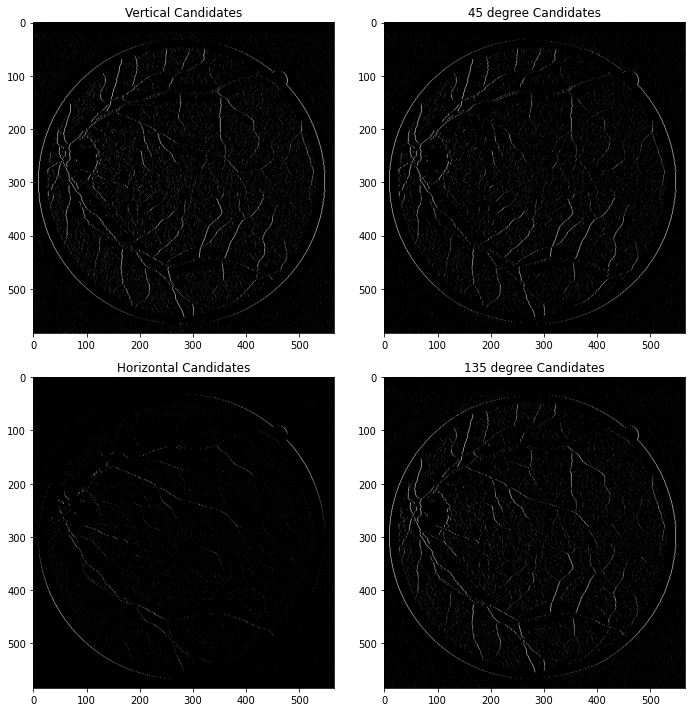

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(c1, cmap="gray")
axs[0, 0].set_title('Vertical Candidates')
axs[0, 1].imshow(c2, cmap="gray")
axs[0, 1].set_title('45 degree Candidates')
axs[1, 0].imshow(c3, cmap="gray")
axs[1, 0].set_title('Horizontal Candidates')
axs[1, 1].imshow(c4, cmap="gray")
axs[1, 1].set_title('135 degree Candidates')
plt.tight_layout()
plt.show()

**Thresholding**
1. Binary
2. Otsu

In [ ]:
def display_candidates(candidate):
    _, candidate_thresh = cv2.threshold(candidate, 127, 255, cv2.THRESH_BINARY)
    _, candidate_thresh_otsu = cv2.threshold(candidate, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

    enhanced_candidate_1 = enhanced.astype('int32') + candidate_thresh.astype('int32')
    enhanced_candidate_1 = np.where(enhanced_candidate_1 > 255, 255, enhanced_candidate_1).astype('uint8')

    enhanced_candidate_2 = enhanced.astype('int32') + candidate_thresh_otsu.astype('int32')
    enhanced_candidate_2 = np.where(enhanced_candidate_2 > 255, 255, enhanced_candidate_2).astype('uint8')

    fig, axs = plt.subplots(3, 2, figsize=(10, 15))

    axs[0, 0].imshow(enhanced, cmap="gray")
    axs[0, 0].set_title('Original')
    axs[0, 1].imshow(candidate, cmap="gray")
    axs[0, 1].set_title('Candidates')

    axs[1, 0].imshow(candidate_thresh, cmap="gray")
    axs[1, 0].set_title('Candidates Thresholded')
    axs[1, 1].imshow(candidate_thresh_otsu, cmap="gray")
    axs[1, 1].set_title('Candidates Otsu Thresholded')

    axs[2, 0].imshow(enhanced_candidate_1, cmap="gray")
    axs[2, 0].set_title('Candidates Thresholded + Enhanced')
    axs[2, 1].imshow(enhanced_candidate_2, cmap="gray")
    axs[2, 1].set_title('Candidates Otsu Thresholded + Enhanced')

    plt.tight_layout()
    plt.show()

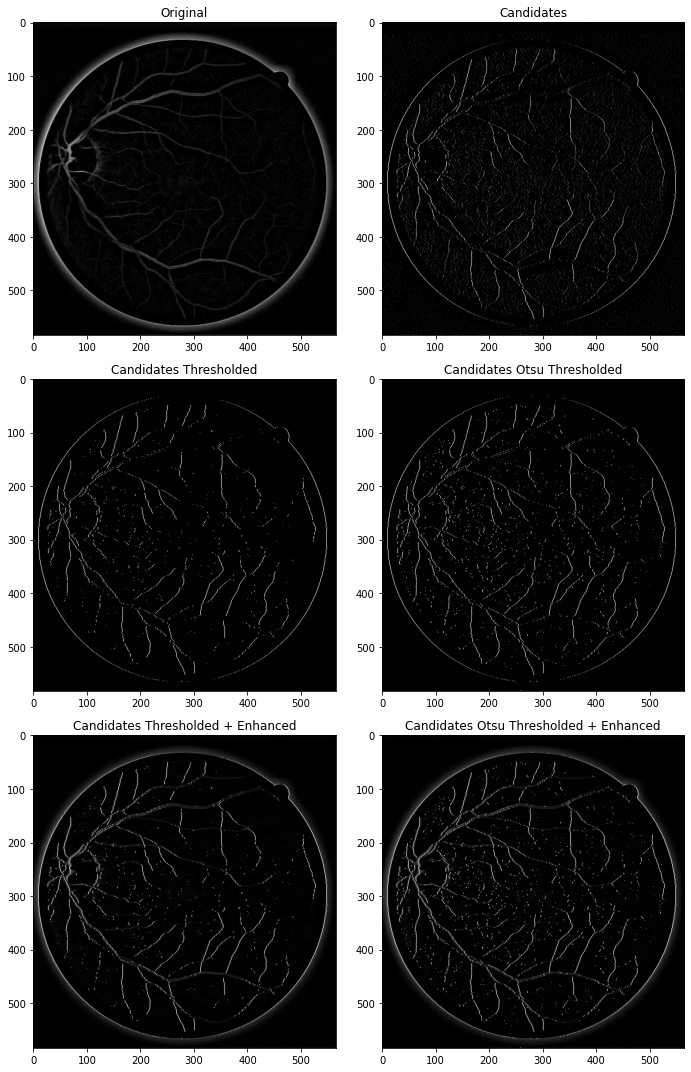

In [ ]:
display_candidates(c1)

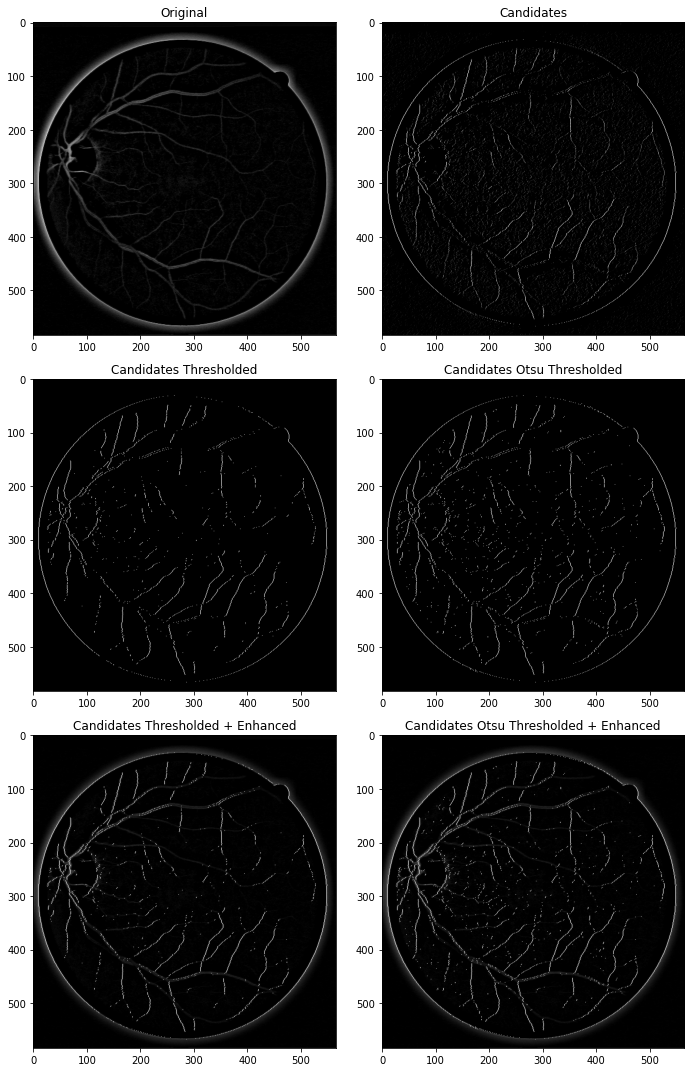

In [ ]:
display_candidates(c2)

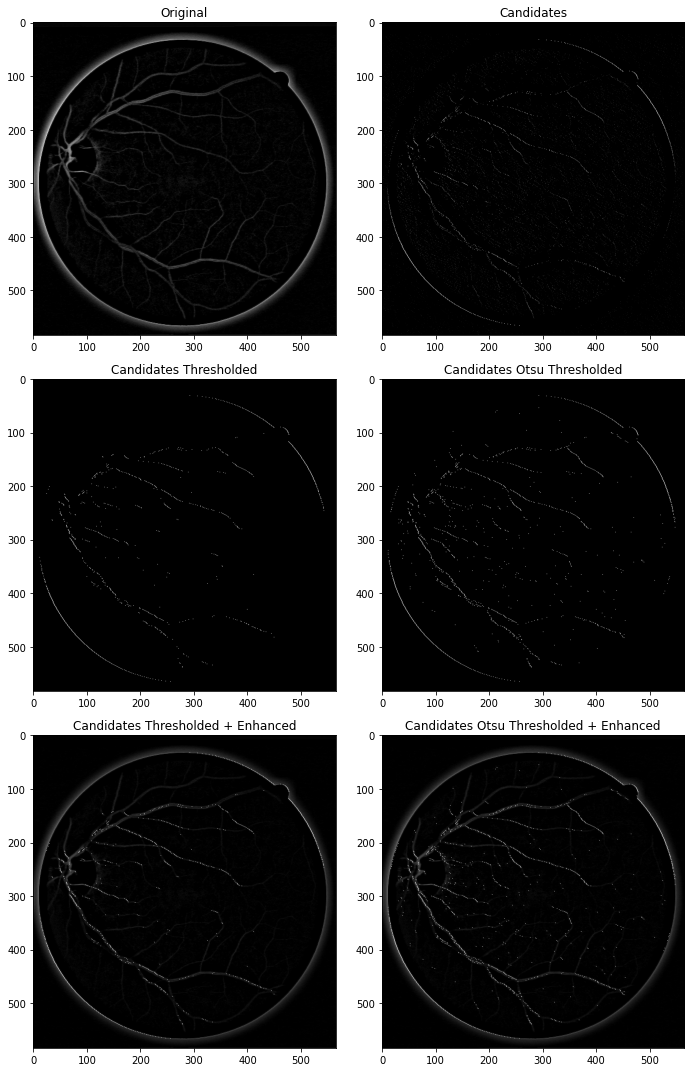

In [ ]:
display_candidates(c3)

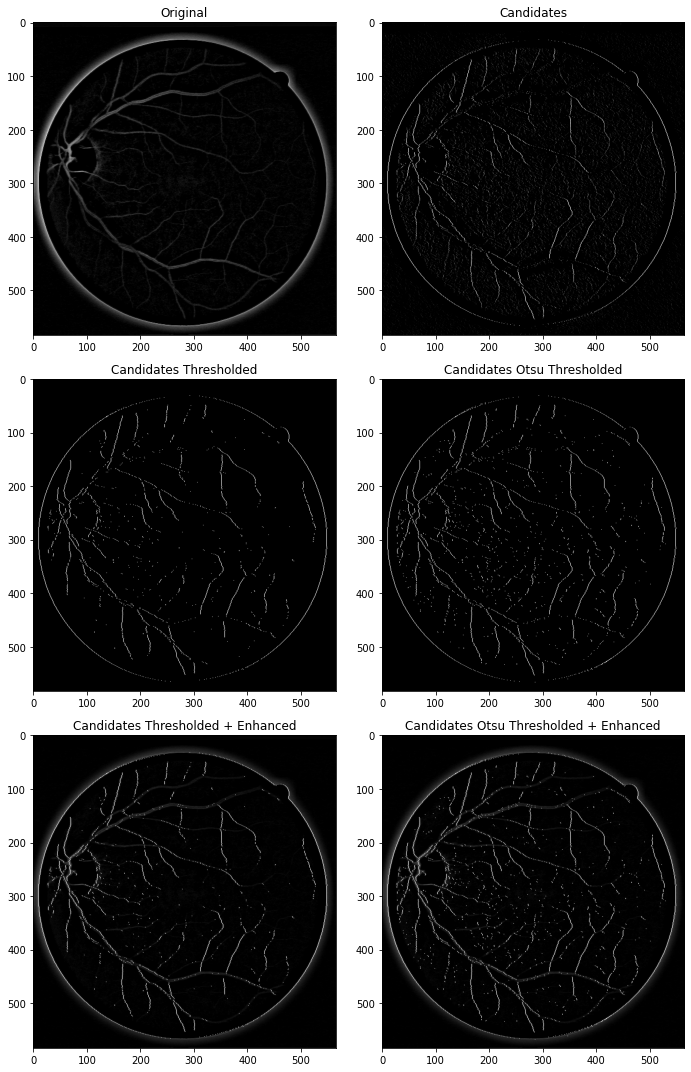

In [ ]:
display_candidates(c4)

### Connection of the candidate points


**Process**
1. Generate histogram for each candidate image
2. Find mean, std, and mode of each histogram
3. $ T_{agg} = $ mode 
4. $ T_{seed} = \mu	- ασ$  

In [ ]:
def get_mode(img):
    flat = img.flatten()
    flat = flat[(flat != 0) & (flat != 255)]
    return mode(flat)[0].item()

def get_mu_and_std(img):
    flat = img.flatten()
    flat = flat[(flat != 0)]
    mu = flat.mean()
    std = flat.std()
    return mu, std
  

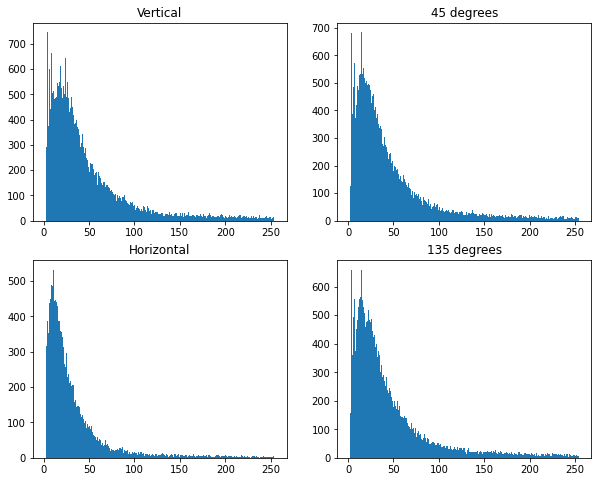

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

c1_flat = c1.flatten()
c1_flat = c1_flat[(c1_flat != 0) & (c1_flat != 255)]
c2_flat = c2.flatten()
c2_flat = c2_flat[(c2_flat != 0) & (c2_flat != 255)]
c3_flat = c3.flatten()
c3_flat = c3_flat[(c3_flat != 0) & (c3_flat != 255)]
c4_flat = c4.flatten()
c4_flat = c4_flat[(c4_flat != 0) & (c4_flat != 255)]

axs[0, 0].hist(c1_flat, range=(1, 255), bins=255)
axs[0, 0].set_title('Vertical')
axs[0, 1].hist(c2_flat, range=(1, 255), bins=255)
axs[0, 1].set_title('45 degrees')
axs[1, 0].hist(c3_flat, range=(1, 255), bins=255)
axs[1, 0].set_title('Horizontal')
axs[1, 1].hist(c4_flat, range=(1, 255), bins=255)
axs[1, 1].set_title('135 degrees')

plt.show()

Selected seeds:
165.614620480851 161.93701933360234 112.8295544043217 161.2174432795012
Selected thresholds:
4 14 10 3


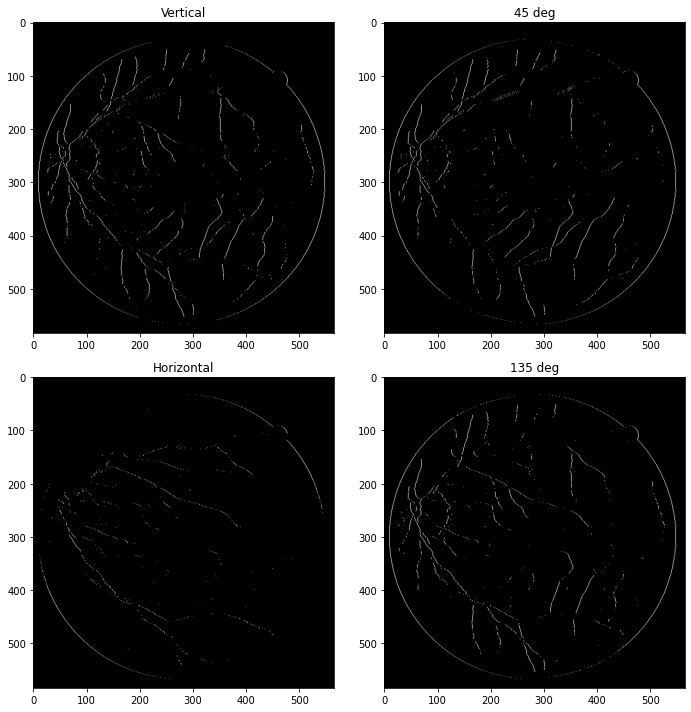

In [ ]:
# aggregation mode
c1_agg_thresh = get_mode(c1)
c2_agg_thresh = get_mode(c2)
c3_agg_thresh = get_mode(c3)
c4_agg_thresh = get_mode(c4)

# mean and standard deviations
c1_mu, c1_std = get_mu_and_std(c1)
c2_mu, c2_std = get_mu_and_std(c2)
c3_mu, c3_std = get_mu_and_std(c3)
c4_mu, c4_std = get_mu_and_std(c4)

# Smaller alpha -> less segments/noise
alpha = -1.5

# Threshold for seeds
c1_thresh_seed = c1_mu - alpha * c1_std
c2_thresh_seed = c2_mu - alpha * c2_std
c3_thresh_seed = c3_mu - alpha * c3_std
c4_thresh_seed = c4_mu - alpha * c4_std

print("Selected seeds:")
print(c1_thresh_seed, c2_thresh_seed, c3_thresh_seed, c4_thresh_seed)

print("Selected thresholds:")
print(c1_agg_thresh, c2_agg_thresh, c3_agg_thresh, c4_agg_thresh)

# the candidates are binarized using threshold for seeds at threshold
c1_seedpoints = cv2.threshold(c1, c1_thresh_seed, 255, cv2.THRESH_BINARY)[1].astype('uint8')
c2_seedpoints = cv2.threshold(c2, c2_thresh_seed, 255, cv2.THRESH_BINARY)[1].astype('uint8')
c3_seedpoints = cv2.threshold(c3, c3_thresh_seed, 255, cv2.THRESH_BINARY)[1].astype('uint8')
c4_seedpoints = cv2.threshold(c4, c4_thresh_seed, 255, cv2.THRESH_BINARY)[1].astype('uint8')

# plot the binarized seeds
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(c1_seedpoints, cmap="gray")
axes[0, 0].set_title("Vertical")
axes[0, 1].imshow(c2_seedpoints, cmap="gray")
axes[0, 1].set_title("45 deg")
axes[1, 0].imshow(c3_seedpoints, cmap="gray")
axes[1, 0].set_title("Horizontal")
axes[1, 1].imshow(c4_seedpoints, cmap="gray")
axes[1, 1].set_title("135 deg")

plt.tight_layout()
plt.show()

In [ ]:
def clean_candidates(candidate, size):
    '''Used to remove noise using connected components algorithm'''
    # find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(candidate, connectivity=8)
    # connectedComponentswithStats yields every seperated component with information on each of them, such as size
    # the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
    sizes = stats[1:, -1]
    nb_components = nb_components - 1

    # minimum size of particles we want to keep (number of pixels)
    # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
    min_size = size

    #your answer image
    img2 = np.zeros((output.shape), dtype='uint8')
    #for every component in the image, you keep it only if it's above min_size
    for i in range(nb_components):
        if sizes[i] >= min_size:
            img2[output == i + 1] = 255

    return img2

from skimage import morphology

def clean_candidates2(candidate, size):
    return morphology.remove_small_objects(candidate, min_size=size, connectivity=4)

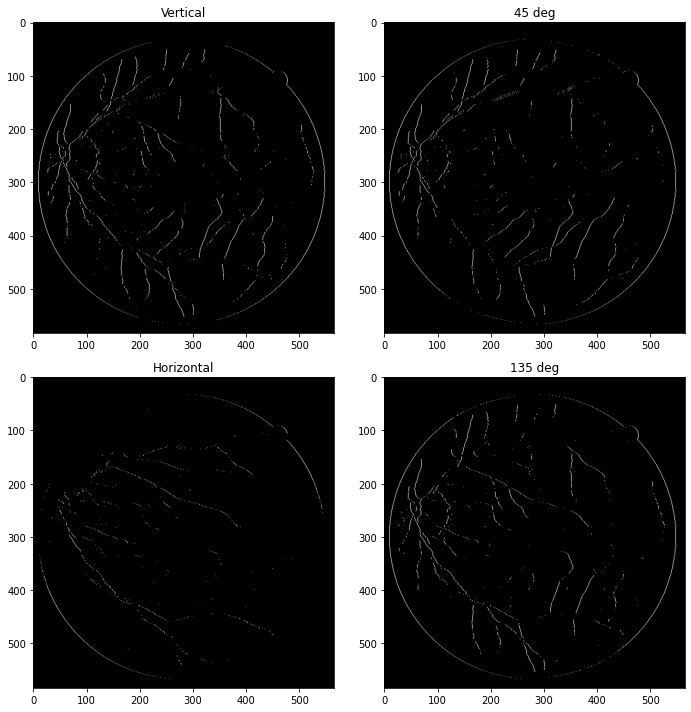

In [ ]:
# minimum sizes of neighborhood
sizes = [2, 2, 1, 2]

c1_clean = clean_candidates2(c1_seedpoints, 18)#clean_candidates(c1_seedpoints, size=sizes[0])
c2_clean = clean_candidates2(c2_seedpoints, 18)#clean_candidates(c2_seedpoints, size=sizes[1])
c3_clean = clean_candidates2(c3_seedpoints, 18)#clean_candidates(c3_seedpoints, size=sizes[2])
c4_clean = clean_candidates2(c4_seedpoints, 18)#clean_candidates(c4_seedpoints, size=sizes[3])

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(c1_clean, cmap="gray")
axes[0, 0].set_title("Vertical")
axes[0, 1].imshow(c2_clean, cmap="gray")
axes[0, 1].set_title("45 deg")
axes[1, 0].imshow(c3_clean, cmap="gray")
axes[1, 0].set_title("Horizontal")
axes[1, 1].imshow(c4_clean, cmap="gray")
axes[1, 1].set_title("135 deg")

plt.tight_layout()
plt.show()

In [ ]:
# find indices where candidate's intensity exceeds threshold for seeds
c1_seeds = np.argwhere(c1_clean > 0)
c2_seeds = np.argwhere(c2_clean > 0)
c3_seeds = np.argwhere(c3_clean > 0)
c4_seeds = np.argwhere(c4_clean > 0)

In [ ]:
# https://developpaper.com/simple-implementation-of-region-growing-in-python/

def getGrayDiff(img, currentPoint, tmpPoint):
    r1, c1 = currentPoint
    r2, c2 = tmpPoint
    diff = img[r1, c1].astype(int) - img[r2, c2].astype(int)
    diff = abs(diff)
    return diff

def selectConnects(p):
    if p != 0:
        connects = [(-1, -1), (0, -1), (1, -1), (1, 0),
                    (1, 1), (0, 1), (-1, 1), (-1, 0)]
    else:
        connects = [(0, -1), (1, 0), (0, 1), (-1, 0)]
    return connects

def regionGrow(img, seeds, thresh, p = 0):
    height, weight = img.shape
    seedMark = np.zeros(img.shape, dtype='uint8')
    seedList = []
    for seed in seeds:
        seedList.append(seed)
    label = 1
    connects = selectConnects(p)
    while len(seedList) > 0:
        currentPoint = seedList.pop(0)
        seedMark[currentPoint[0], currentPoint[1]] = label
        for i in range(len(connects)):
            tmpX = currentPoint[0] + connects[i][0]
            tmpY = currentPoint[1] + connects[i][1]
            if tmpX < 0 or tmpY < 0 or tmpX >= height or tmpY >= weight:
                continue
            grayDiff = getGrayDiff(img, currentPoint, (tmpX, tmpY))
            if grayDiff < thresh and seedMark[tmpX, tmpY] == 0:
                seedMark[tmpX, tmpY] = label
                seedList.append((tmpX, tmpY))
    return seedMark

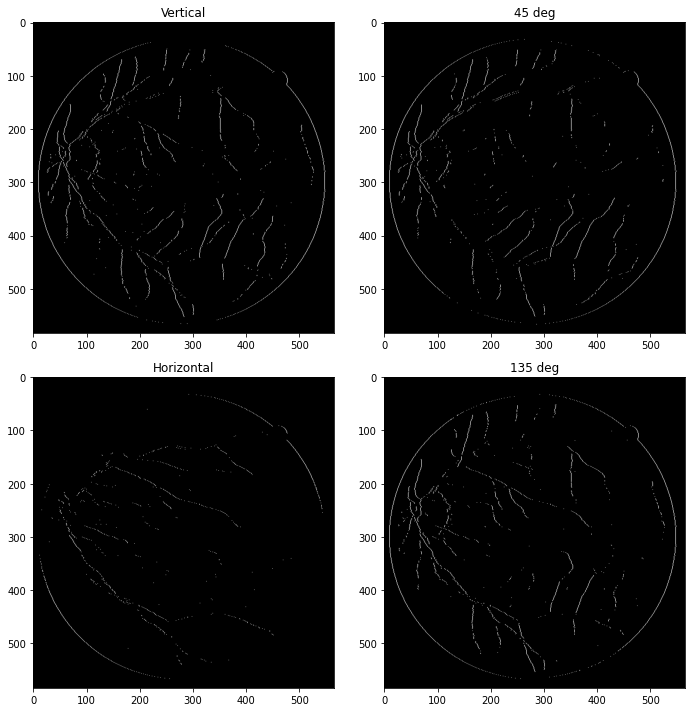

In [ ]:
c1_rg = regionGrow(c1, c1_seeds, c1_agg_thresh, 1)
c2_rg = regionGrow(c2, c2_seeds, c2_agg_thresh, 1)
c3_rg = regionGrow(c3, c3_seeds, c3_agg_thresh, 1)
c4_rg = regionGrow(c4, c4_seeds, c4_agg_thresh, 1)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(c1_rg, cmap="gray")
axes[0, 0].set_title("Vertical")
axes[0, 1].imshow(c2_rg, cmap="gray")
axes[0, 1].set_title("45 deg")
axes[1, 0].imshow(c3_rg, cmap="gray")
axes[1, 0].set_title("Horizontal")
axes[1, 1].imshow(c4_rg, cmap="gray")
axes[1, 1].set_title("135 deg")

plt.tight_layout()
plt.show()

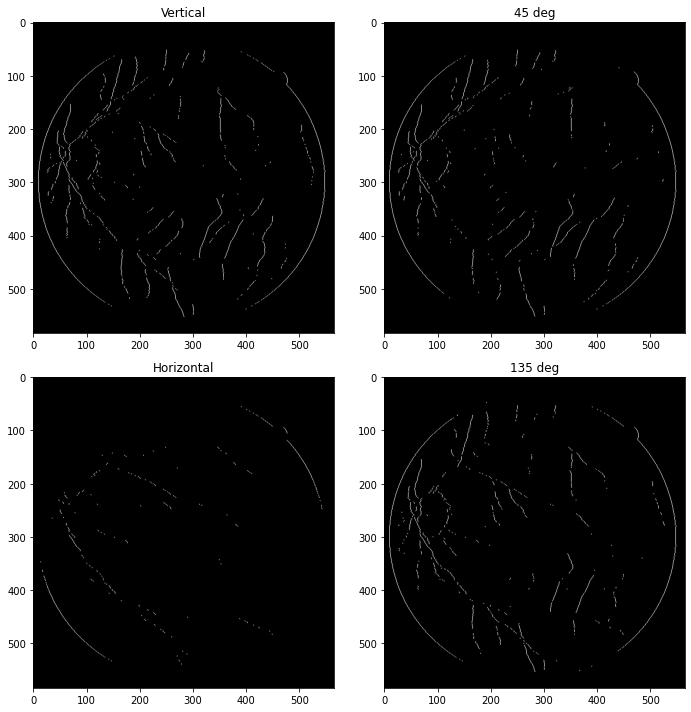

In [ ]:
# Remove isolated segments
c1_clean = clean_candidates(c1_rg, size=2)
c2_clean = clean_candidates(c2_rg, size=2)
c3_clean = clean_candidates(c3_rg, size=2)
c4_clean = clean_candidates(c4_rg, size=2)


fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(c1_clean, cmap="gray")
axes[0, 0].set_title("Vertical")
axes[0, 1].imshow(c2_clean, cmap="gray")
axes[0, 1].set_title("45 deg")
axes[1, 0].imshow(c3_clean, cmap="gray")
axes[1, 0].set_title("Horizontal")
axes[1, 1].imshow(c4_clean, cmap="gray")
axes[1, 1].set_title("135 deg")

plt.tight_layout()
plt.show()

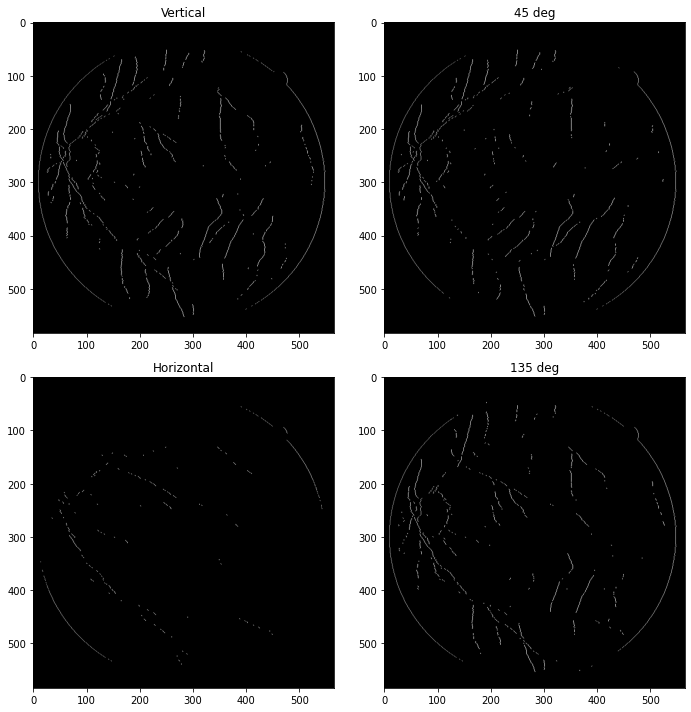

In [ ]:
# each pixel of an image resulting from the region growing process is multiplied
# by the corresponding pixel value in the background normalized image 
c1_clean = c1_clean.astype('uint8') * enhanced
c2_clean = c2_clean.astype('uint8') * enhanced
c3_clean = c3_clean.astype('uint8') * enhanced
c4_clean = c4_clean.astype('uint8') * enhanced

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(c1_clean, cmap="gray")
axes[0, 0].set_title("Vertical")
axes[0, 1].imshow(c2_clean, cmap="gray")
axes[0, 1].set_title("45 deg")
axes[1, 0].imshow(c3_clean, cmap="gray")
axes[1, 0].set_title("Horizontal")
axes[1, 1].imshow(c4_clean, cmap="gray")
axes[1, 1].set_title("135 deg")

plt.tight_layout()
plt.show()

### Validation Of Centerlines

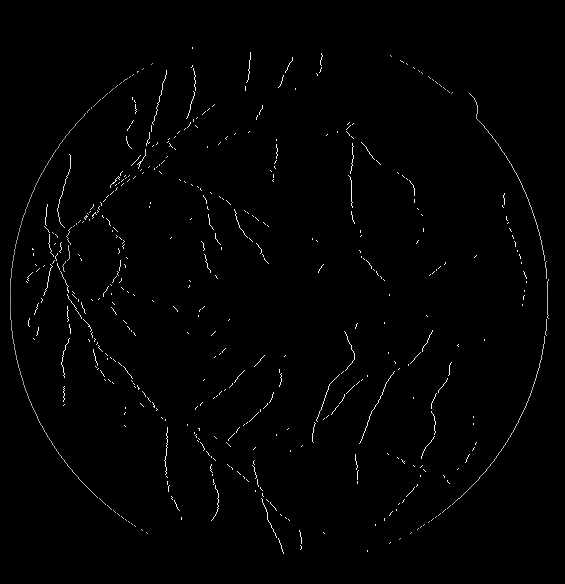

In [ ]:
# get maximum of a
f1 = np.maximum(c1_clean, c2_clean)
f2 = np.maximum(c3_clean, c4_clean)
f = np.maximum(f1, f2)
Image.fromarray(f)

## **Task 2**: Vessel Segmentation

### Vessel Enhancement



**Modified top hat**


In [ ]:
# Circular structure elements of radius 1 to 8
circle1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(1,1))
circle2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(2,2))
circle3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
circle4 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(4,4))
circle5 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
circle6 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))
circle7 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
circle8 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8,8))

In [ ]:
# modified top hat
normalized1 = np.minimum(bg_normalized,cv2.erode(cv2.dilate(bg_normalized, circle1), circle1))
normalized2 = np.minimum(bg_normalized,cv2.erode(cv2.dilate(bg_normalized, circle1), circle2))
normalized3 = np.minimum(bg_normalized,cv2.erode(cv2.dilate(bg_normalized, circle1), circle3))
normalized4 = np.minimum(bg_normalized,cv2.erode(cv2.dilate(bg_normalized, circle1), circle4))
normalized5 = np.minimum(bg_normalized,cv2.erode(cv2.dilate(bg_normalized, circle1), circle5))
normalized6 = np.minimum(bg_normalized,cv2.erode(cv2.dilate(bg_normalized, circle1), circle6))
normalized7 = np.minimum(bg_normalized,cv2.erode(cv2.dilate(bg_normalized, circle1), circle7))
normalized8 = np.minimum(bg_normalized,cv2.erode(cv2.dilate(bg_normalized, circle1), circle8))



In [ ]:
# Subtract from background normalized
normalized1 = (bg_normalized.astype('int') - normalized1.astype('int')).astype('uint8')
normalized2 = (bg_normalized.astype('int') - normalized2.astype('int')).astype('uint8')
normalized3 = (bg_normalized.astype('int') - normalized3.astype('int')).astype('uint8')
normalized4 = (bg_normalized.astype('int') - normalized4.astype('int')).astype('uint8')
normalized5 = (bg_normalized.astype('int') - normalized5.astype('int')).astype('uint8')
normalized6 = (bg_normalized.astype('int') - normalized6.astype('int')).astype('uint8')
normalized7 = (bg_normalized.astype('int') - normalized7.astype('int')).astype('uint8')
normalized8 = (bg_normalized.astype('int') - normalized8.astype('int')).astype('uint8')

** Combine Results**

In [ ]:
# function to take average of two images
def avg_images(img1,img2):
  image_data = [img1,img2]
  avg_image = image_data[0]
  avg_image = cv2.addWeighted(image_data[1], 0.5, avg_image, 0.5, 0.0)
  return avg_image

In [ ]:
# Average each two consecutive images
normalized12 = avg_images(normalized1,normalized2)
normalized34 = avg_images(normalized3,normalized4)
normalized56 = avg_images(normalized5,normalized6)
normalized78 = avg_images(normalized7,normalized8)


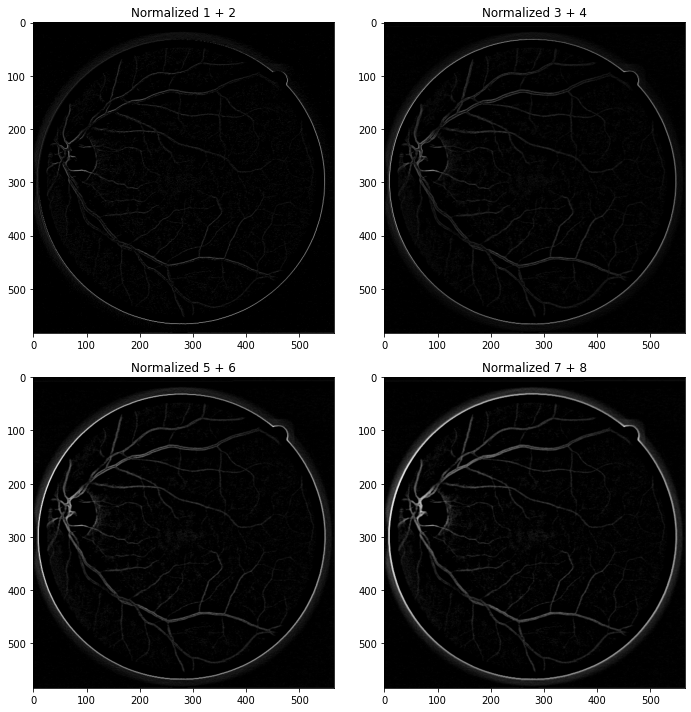

In [ ]:
# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(normalized12, cmap="gray")
axes[0, 0].set_title("Normalized 1 + 2")
axes[0, 1].imshow(normalized34, cmap="gray")
axes[0, 1].set_title("Normalized 3 + 4")
axes[1, 0].imshow(normalized56, cmap="gray")
axes[1, 0].set_title("Normalized 5 + 6")
axes[1, 1].imshow(normalized78, cmap="gray")
axes[1, 1].set_title("Normalized 7 + 8")

plt.tight_layout()
plt.show()

## Multiscale Reconstruction

**Double Thresholding Process:**
1. Plot the intensity histogram for each image to obtain a visual representation
1. Select seeds for marker and mask image using percentile of intensity histogram 
2. Threshold each image for two ranges of gray values,
one being included in the other

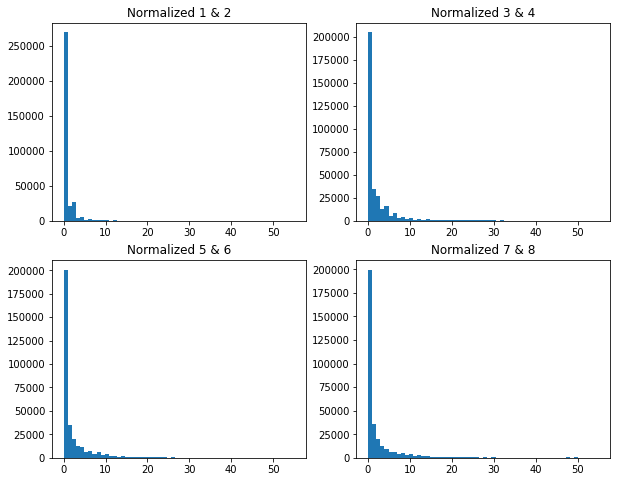

In [ ]:
# Plot 4 histograms seperately
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

n1_flat = normalized12.flatten()
#n1_flat = n1_flat[n1_flat != 0]
n2_flat = normalized34.flatten()
#n2_flat = n2_flat[n2_flat != 0]
n3_flat = normalized56.flatten()
#n3_flat = n3_flat[n3_flat != 0]
n4_flat = normalized78.flatten()
#n4_flat = n4_flat[n4_flat != 0]

axs[0, 0].hist(n1_flat, range=(0, 55), bins=56)
axs[0, 0].set_title('Normalized 1 & 2')
axs[0, 1].hist(n2_flat, range=(0, 55), bins=56)
axs[0, 1].set_title('Normalized 3 & 4')
axs[1, 0].hist(n3_flat, range=(0, 55), bins=56)
axs[1, 0].set_title('Normalized 5 & 6')
axs[1, 1].hist(n4_flat, range=(0, 55), bins=56)
axs[1, 1].set_title('Normalized 7 & 8')

plt.show()

In [ ]:
# function to obtain masker and mask seeds
def obtain_seeds(img, marker_pc, mask_pc):
  marker_seed = np.percentile(img, 100 - marker_pc) 
  mask_seed = mask = np.percentile(img, 100 - mask_pc)
  return marker_seed, mask_seed

In [ ]:
# function to apply double thresholding opeator
def double_thresholding(img, marker_seed, mask_seed):
  marker_image = np.where(img > marker_seed, 255, img).astype('uint8')
  mask_image = np.where(img > mask_seed, 255, img).astype('uint8')
  return marker_image, mask_image

In [ ]:
# obtain marker and mask seeds
mr1, ms1 = obtain_seeds(n1_flat, 5, 25)
mr2, ms2 = obtain_seeds(n2_flat, 2, 20)
mr3, ms3 = obtain_seeds(n3_flat, 1, 10)
mr4, ms4 = obtain_seeds(n4_flat, 1, 10)

# obtain marker and masked thresholded image using their respective seeds
marker_image1, mask_image1 = double_thresholding(normalized12, mr1, ms1)
marker_image2, mask_image2 = double_thresholding(normalized34, mr2, ms2)
marker_image3, mask_image3 = double_thresholding(normalized56, mr3, ms3)
marker_image4, mask_image4 = double_thresholding(normalized78, mr4, ms4)

# Combine the marker and masked images using binary morpholocal operation of reconstruction
m1 = reconstruction(marker_image1, mask_image1).astype('uint8')
m2 = reconstruction(marker_image2, mask_image2).astype('uint8')
m3 = reconstruction(marker_image3, mask_image3).astype('uint8')
m4 = reconstruction(marker_image4, mask_image4).astype('uint8')

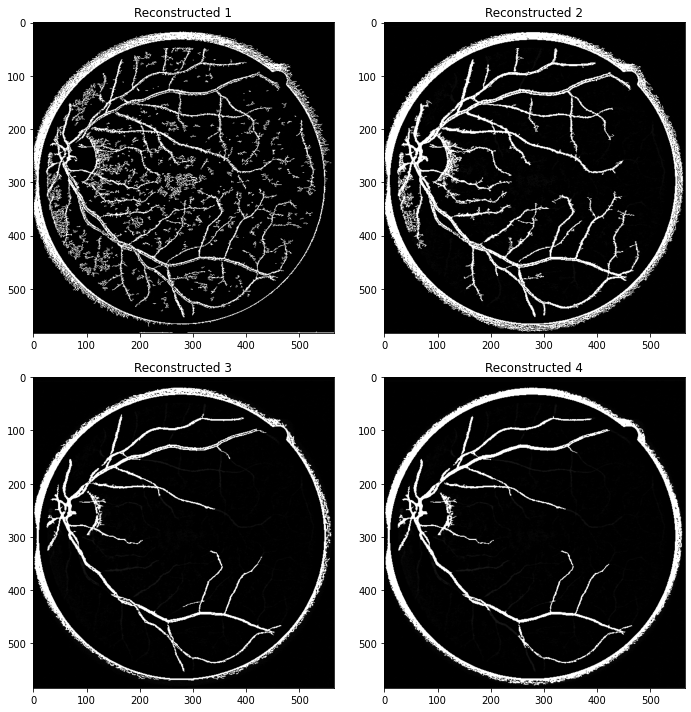

In [ ]:
# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(m1, cmap="gray")
axes[0, 0].set_title("Reconstructed 1")
axes[0, 1].imshow(m2, cmap="gray")
axes[0, 1].set_title("Reconstructed 2")
axes[1, 0].imshow(m3, cmap="gray")
axes[1, 0].set_title("Reconstructed 3")
axes[1, 1].imshow(m4, cmap="gray")
axes[1, 1].set_title("Reconstructed 4")

plt.tight_layout()
plt.show()

## Vessel Filling

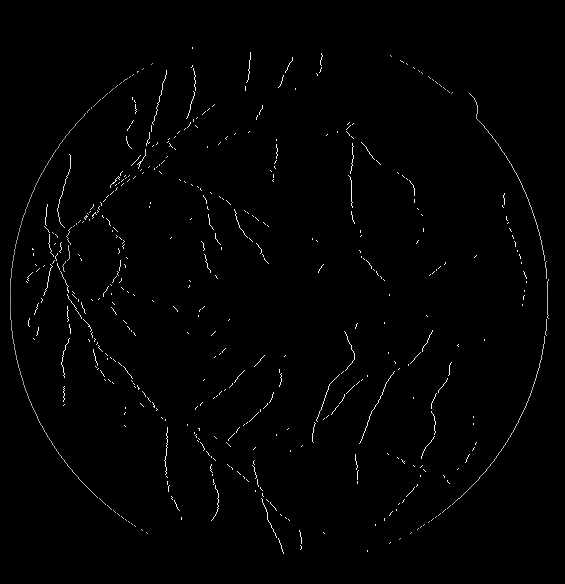

In [ ]:
vcp = f
Image.fromarray(vcp) 

(106593,)


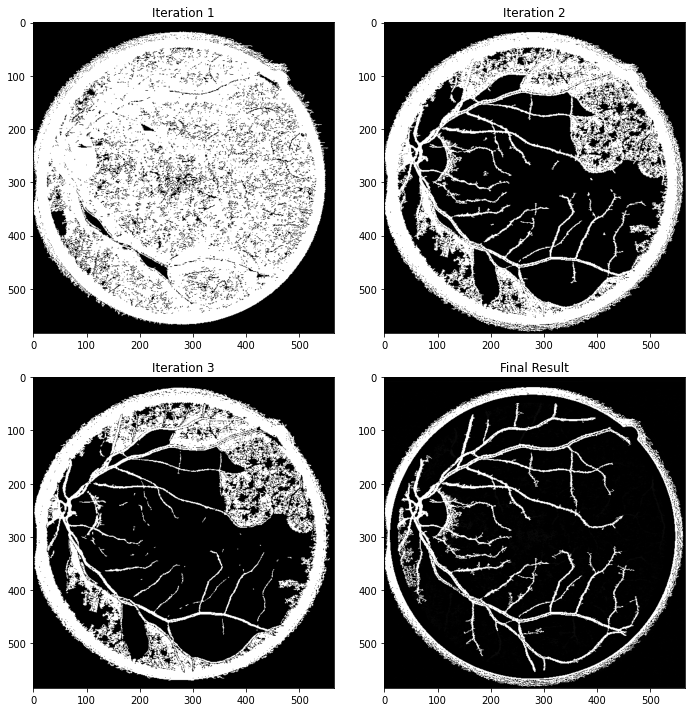

In [ ]:
th, vcp = cv2.threshold(vcp, 200, 255, cv2.THRESH_OTSU)
th, out1 = cv2.threshold(vcp, 128, 255, cv2.THRESH_OTSU)
th, out2 = cv2.threshold(vcp, 128, 255, cv2.THRESH_OTSU)
th, out3 = cv2.threshold(vcp, 128, 255, cv2.THRESH_OTSU)
th, out4 = cv2.threshold(vcp, 128, 255, cv2.THRESH_OTSU)

out1 = regionGrow(m1, np.argwhere(vcp == 255) , get_mode(m1))
out2 = regionGrow(m2, np.argwhere(vcp == 255), get_mode(m2))
out3 = regionGrow(m3, np.argwhere(vcp == 255), get_mode(m3))
out4 = regionGrow(m4, np.argwhere(vcp == 255), get_mode(m4))

print(out2[out2 == 1].shape)

out1 = np.where( out1 == 1, 255, out1)
out2 = np.where( out2 == 1, 255, out2)
out3 = np.where( out3 == 1, 255, out3)
out4 = np.where( out4 == 1, 255, out4)


# Plot the results
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0, 0].imshow(out1, cmap="gray")
axes[0, 0].set_title("Iteration 1")
axes[0, 1].imshow(out2, cmap="gray")
axes[0, 1].set_title("Iteration 2")
axes[1, 0].imshow(out3, cmap="gray")
axes[1, 0].set_title("Iteration 3")
axes[1, 1].imshow(m2, cmap="gray")
axes[1, 1].set_title("Final Result")

plt.tight_layout()
plt.show()


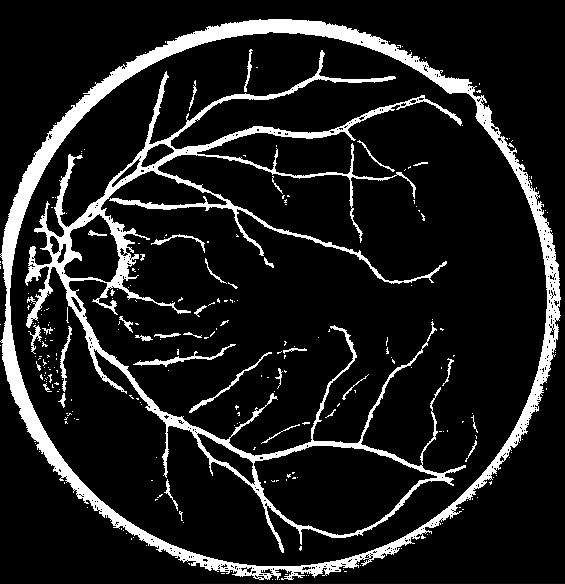

In [ ]:
def clean_image(input):
    output = input.copy()  
    def eight_n(inp,i,j):
      n = inp[i-1,j]
      ne = inp[i-1,j+1]
      e = inp[i,j+1]
      se = inp[i+1,j+1]
      s = inp[i+1,j]
      sw = inp[i+1,j-1]
      w = inp[i,j-1]
      nw = inp[i-1,j-1]
      #print(sum([n,ne,e,e,se,s,sw,w,nw]))

      if (sum([n,ne,e,e,se,s,sw,w,nw]) >= 6 * 255):
        return 255
      return 0
    for i in range(1,input.shape[0]-1):
      for j in range(1,input.shape[1]-1):
        output[i,j] = eight_n(input,i,j)
    return output

final_result = clean_image(out4)
Image.fromarray(final_result)

In [ ]:
def remove_large_object(candidate, size):
    '''Used to remove noise using connected components algorithm'''
    # find all your connected components (white blobs in your image)
    nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(candidate, connectivity=8)
    # connectedComponentswithStats yields every seperated component with information on each of them, such as size
    # the following part is just taking out the background which is also considered a component, but most of the time we don't want that.
    sizes = stats[1:, -1]
    nb_components = nb_components - 1

    # minimum size of particles we want to keep (number of pixels)
    # here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
    min_size = size

    #your answer image
    img2 = np.zeros((output.shape), dtype='uint8')
    #for every component in the image, you keep it only if it's above min_size
    for i in range(nb_components):
        if sizes[i] < min_size:
            img2[output == i + 1] = 255

    return img2

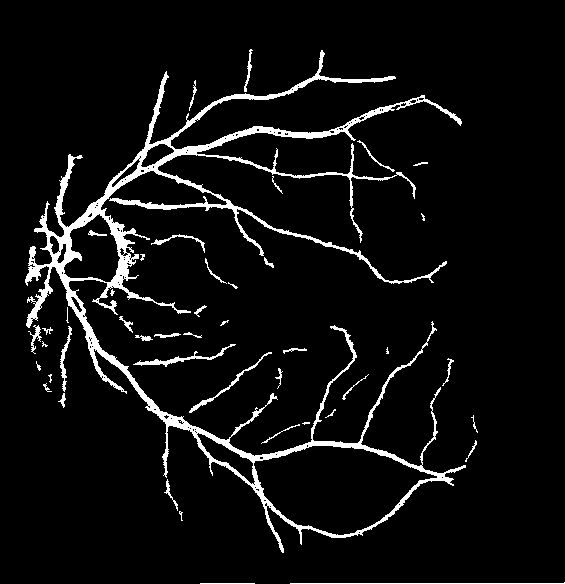

In [ ]:
# remove circular object around  vessels 
output = remove_large_object(final_result, 19504)

# remove small noise
final_output = clean_candidates(output, 12)

# final output 
Image.fromarray(final_output)

#FINALLY DONE!!!....

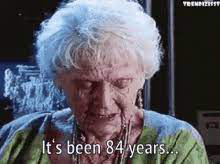

In [ ]:
Image.open('84years.jpg')